In [1]:
#Importamos librerias
#Tokenizar
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer #Procesamiento de texto
from nltk.corpus import stopwords #Para limpiar palabras irrelevantes en la tokenización

#Para mover strings ...
import re
import string
from bs4 import BeautifulSoup #Contabilizar tokens
from collections import Counter #Contabilizar

import pandas as pd #Pandas
import numpy as np # linear
import seaborn as sns #Seaborn
import matplotlib.pyplot as plt #Graficar
%matplotlib inline

# más gráficas
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.model_selection import train_test_split #Para hacer la 
from sklearn.metrics import confusion_matrix #Matriz de confusión
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.feature_extraction.text import TfidfVectorizer #Para hacer vectorización
from sklearn.naive_bayes import MultinomialNB #Naive Bayes
from sklearn import metrics

In [2]:
#Leemos el archivo y verificamos las características de los campos
df=pd.read_excel('../Práctica6/6.5. EmployeeData.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1717 entries, 0 to 1716
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CanDoBetter       1689 non-null   object 
 1   ID                1715 non-null   float64
 2   Training          1715 non-null   object 
 3   Est_Income        1715 non-null   float64
 4   Benefit           1715 non-null   object 
 5   length_of_hire    1715 non-null   float64
 6   Facility          1715 non-null   object 
 7   DriveTime         1715 non-null   object 
 8   Marital           1715 non-null   object 
 9   SpousalBenefit    1715 non-null   object 
 10  StockPlan         1715 non-null   object 
 11  TrainingRecieved  1715 non-null   object 
 12  PositionType      1715 non-null   object 
 13  Education         1715 non-null   object 
 14  Status            1715 non-null   object 
dtypes: float64(3), object(12)
memory usage: 201.3+ KB


In [3]:
#Reemplazamos valores en Status
df.Status=df.Status.replace({"Current":1,"Past":0})

In [4]:
#Eliminamos duplicados ya que no aportan nada para la predicción y verificamos sí hubo algún cambio
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.isnull().sum()

CanDoBetter         27
ID                   1
Training             1
Est_Income           1
Benefit              1
length_of_hire       1
Facility             1
DriveTime            1
Marital              1
SpousalBenefit       1
StockPlan            1
TrainingRecieved     1
PositionType         1
Education            1
Status               1
dtype: int64

In [5]:
#Eliminamos los registros con valores en nulo ya que son pocos y no son relevantes para el modelo
df=df.dropna()
df.isnull().sum()

CanDoBetter         0
ID                  0
Training            0
Est_Income          0
Benefit             0
length_of_hire      0
Facility            0
DriveTime           0
Marital             0
SpousalBenefit      0
StockPlan           0
TrainingRecieved    0
PositionType        0
Education           0
Status              0
dtype: int64

In [6]:
#Limpiamos palabras de la columna "CanDoBetter"
stemmer = PorterStemmer()
words = stopwords.words("english","spanish")
df['processedtext'] = df['CanDoBetter'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

In [7]:
#Observamos la forma del DF y los resultados del procesamiento
print(df.shape)
df.head(3)

(1689, 16)


,CanDoBetter,ID,Training,Est_Income,Benefit,length_of_hire,Facility,DriveTime,Marital,SpousalBenefit,StockPlan,TrainingRecieved,PositionType,Education,Status,processedtext
0,better non-monetary benefits.,2181.0,Y,60095.20000,Y,58.479532,Facility A,More than 90 mnts,Married,Yes,Yes,No,Sales,"Associate, High school, or Certification",1.0,better non monetari benefit
1,company outings,2829.0,Y,47049.07979,N,35.714286,Facility B,0-30 mnts,Married,Yes,No,Yes,Sales,"Associate, High school, or Certification",1.0,compani outing
2,"Having more safety meeting, and discussing wha...",2144.0,Y,60724.12250,Y,17.152659,Facility B,60-90 mnts,Married,Yes,Yes,Yes,Sales,Masters Degree,0.0,have safeti meet discuss need done day start k...


In [8]:
#Entrenamos el modelo
target = df['Status']

X_train, X_test, y_train, y_test = train_test_split(df['processedtext'], target, test_size=0.30, random_state=100)

print(df.shape); print(X_train.shape); print(X_test.shape)

(1689, 16)
(1182,)
(507,)


Usamos el primer Algorítmo TfidfVectorizer, sirve para contabilizar la frecuencia del texto, y lo hacemos en inglés porque todos los valores están en inglés y agregué también el Español para evitar errores

In [9]:
#Aplicación del vector y conteo de palabras
vectorizer_tfidf = TfidfVectorizer(stop_words=('english','spanish'), max_df=0.7)

train_tfIdf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))

test_tfIdf = vectorizer_tfidf.transform(X_test.values.astype('U'))

print(vectorizer_tfidf.get_feature_names()[:10])

['abras', 'accord', 'achiev', 'acknowledg', 'acquisit', 'across', 'act', 'action', 'activ', 'actual']


In [10]:
#Predicción del entrenamiento
print(train_tfIdf.shape); print(test_tfIdf.shape)

(1182, 694)
(507, 694)


Algoritmo Naive Bayes Multinomial

In [11]:
nb_classifier = MultinomialNB()

nb_classifier.fit(train_tfIdf, y_train)

pred2 = nb_classifier.predict(test_tfIdf) 
print(pred2[:10])

[0. 1. 0. 0. 1. 1. 0. 0. 1. 0.]


In [12]:
accuracy_tfidf = metrics.accuracy_score(y_test, pred2)
print(accuracy_tfidf)

#conf_metrics_tfidf = metrics.confusion_matrix(y_test, pred2, labels=['1', '0']) print(conf_metrics_tfidf)

0.757396449704142


Random Forest

In [13]:
#Clasificación con Random Forest
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 100)

classifier.fit(train_tfIdf, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

In [14]:
#Predicción de la alta y baja de empleados
predRF = classifier.predict(test_tfIdf) 
print(predRF[:10])

#Calculo del Accuracy
accuracy_RF = metrics.accuracy_score(y_test, predRF)
print(accuracy_RF)

[0. 1. 0. 1. 1. 1. 0. 0. 1. 0.]
0.7199211045364892


Tokenización de frases para entender un poco más las opiniones de los empleados

In [15]:
tokens=df.processedtext

In [16]:
#Extraemos la frecuencia de la tokenización
freq = nltk.FreqDist(tokens)

for key,val in freq.items():

    print (str(key) + ':' + str(val))

better non monetari benefit:1
compani outing:20
have safeti meet discuss need done day start keep open line employe i feel need happen job:1
careerpromot:111
i want answer:1
board member listen:1
pay even if new employe start higher pay employe year job right:1
recogn good work:7
boot plan retir day could care less job peopl kind boss still run show unfortun govern relat tenur big thing safe end:1
treat employe respect:17
higher wage:2
pension:172
know:6
k pension rais industri standard:1
noth:153
pay:165
i satisfi:1
higher pay:1
compani sponsor work eve:5
better pay incent:19
they could commun better let us know go decis made don leav us dark:1
recogn reward good employe:6
better pay:10
better pay benefit:7
allow advanc:1
listen take action:30
they practic preach hold manag code conduct hold employe:1
n c:1
listen:4
pension rais:1
social event:89
focus perform across busi therebi reward contribut:1
listen employe:6
we need train date skill:1
period extra incent:1
offer fair compens th

meet individu need:1
offer flexibl schedul depart:1
could recogn employe:1
revers cutback:1
free park:1
listen and take action:1
tri offer benefit:1
pay base on perform train staff to learn differ task:1
again place much emphasi sick time perfect attend:1
keep improv channel employe feedback:1
for starter take activ interest profession develop employe we lost twenti good profession place appear activ disinterest employe clear care:1
listen follow:1
treat employe better respect:1
rais offer overtim etc:1
i think anyth far posit concern:1
make one chang year come suggest:1
give merit increas bonus stop give preferenti treatment peopl like fire peopl incompet:1
do compani sponsor event:1
employe depart overwork:1
show proper respect employe treat like brain good idea:1
provid benefit part time employe not fill paper work get paid:1
higher pension compens:1
acknowledg superior achiev vacat time:1
better faster decis make improv commun corpor employe locat locat:1
reward peopl accord work a

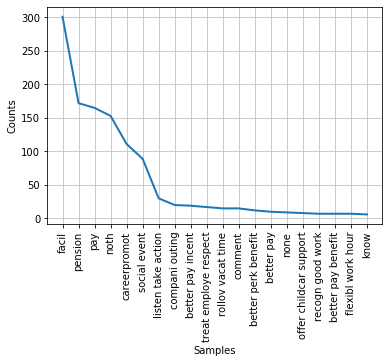

In [17]:
#Gráfico con más visibilidad
freq.plot(20,cumulative=False)

Analizaremos más a fondo sobre los empleados que se fueron, realizando el mismo conteo de palabras sobre los empleados que ya no estan

In [18]:
#Copia del DF
past=df

In [19]:
#Eliminamos a los empleados actuales
past=past.drop(past[past.Status >= 1].index)
past.shape

(752, 16)

In [20]:
token=past.processedtext

In [21]:
#Extraemos la frecuencia de la tokenización
fre = nltk.FreqDist(token)

for key,val in fre.items():

    print (str(key) + ':' + str(val))

have safeti meet discuss need done day start keep open line employe i feel need happen job:1
careerpromot:103
i want answer:1
board member listen:1
pay even if new employe start higher pay employe year job right:1
recogn good work:2
boot plan retir day could care less job peopl kind boss still run show unfortun govern relat tenur big thing safe end:1
treat employe respect:12
higher wage:1
know:4
i satisfi:1
compani sponsor work eve:3
better pay incent:11
recogn reward good employe:3
better pay benefit:5
allow advanc:1
pay:59
listen take action:14
they practic preach hold manag code conduct hold employe:1
n c:1
listen:3
offer fair compens thi like mani compani higher up get big buck rank file get littl rais thi compani could buck trend fell line in way differ mani place:1
there careerpromot i would chang one way:1
retir fund:1
make perk benefit appeal:2
stop reward across board give credit due:1
offer incent:1
offer childcar support:4
better perk benefit:5
not reorgan everi year two con

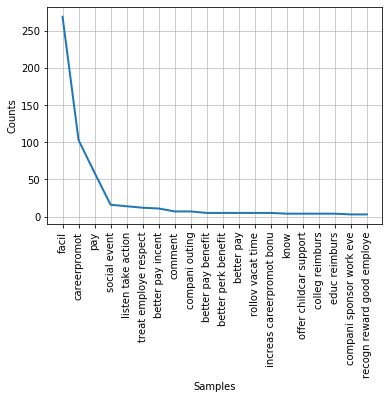

In [22]:
#Gráfico con más visibilidad
fre.plot(20,cumulative=False)

Analizamos más la información del resto de los campos para dar más insights para el negocio

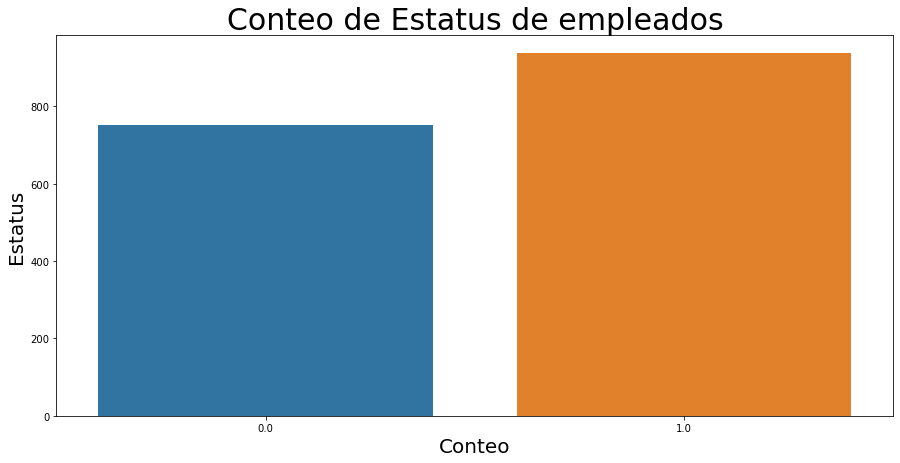

1.0    937
0.0    752
Name: Status, dtype: int64
1.0    55.476613
0.0    44.523387
Name: Status, dtype: float64


In [23]:
#Total de empleados que aún siguen/dejaron la compañia

Estatus=df.Status.rename({0:"Exempleado",1:"Empleado actual"})

fig = plt.figure(figsize=(15,7))
sns.countplot(Estatus)
plt.xlabel('Conteo',fontsize=20)
plt.ylabel('Estatus',fontsize=20)
plt.title('Conteo de Estatus de empleados', fontsize=30)
plt.show()
n_employees = len(df)

# El número de empleados que están y se fueron
print(df.Status.value_counts())

# El porcentaje
print(df.Status.value_counts()/n_employees*100)

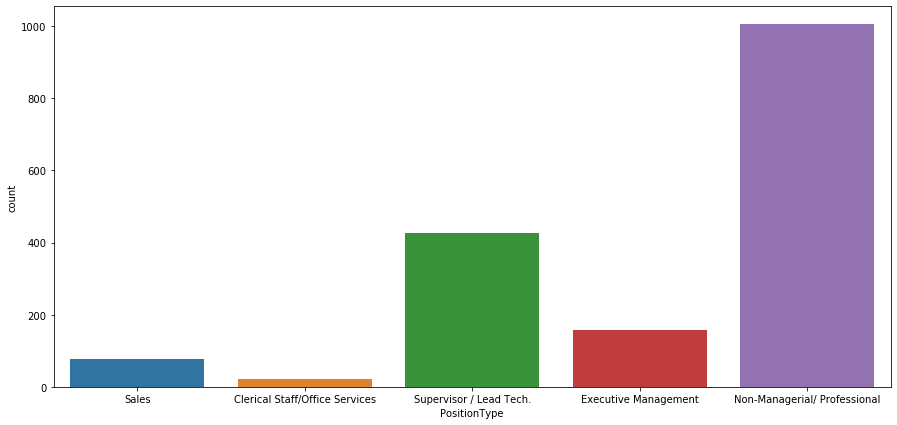

In [24]:
#Verificamos donde están ubicados los empleados
fig = plt.figure(figsize=(15,7))
sns.countplot(x='PositionType',data=df)
plt.show()

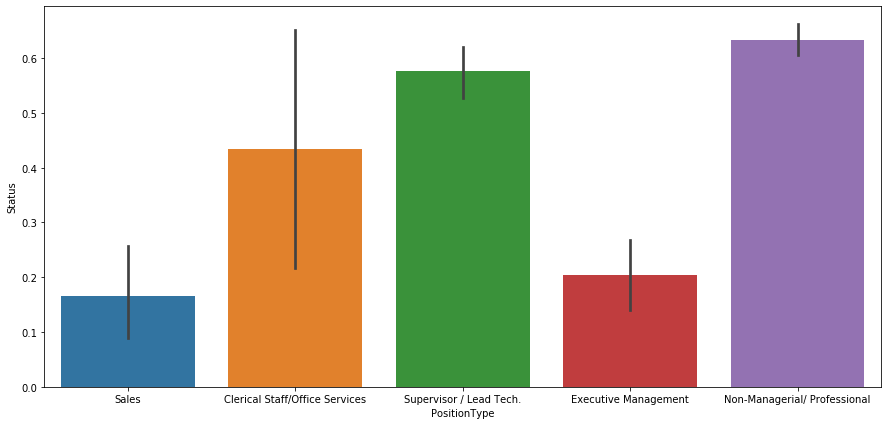

In [25]:
#Observamos de qué área se van más los empleados
fig = plt.figure(figsize=(15,7))
sns.barplot(x='PositionType',y='Status',data=df)
plt.show()

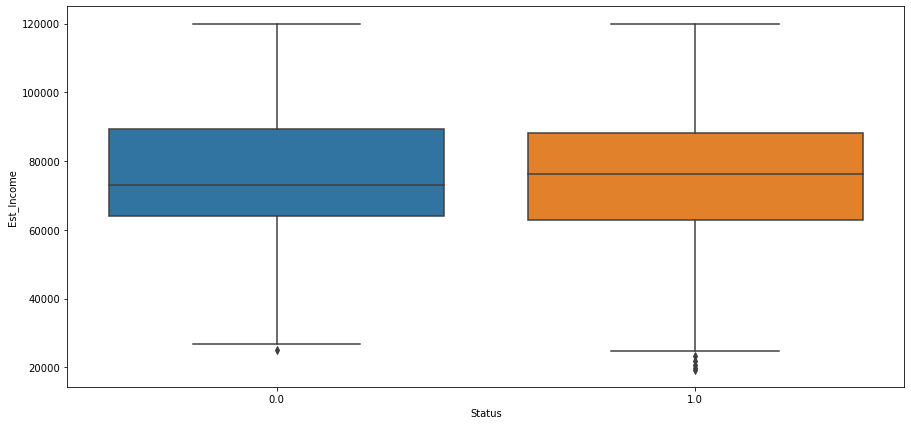

In [26]:
#Verificamos los diferentes salarios y comparamos entre los empleados que siguen y los que no están más
fig = plt.figure(figsize=(15,7))
sns.boxplot(x='Status',y='Est_Income',data=df)
plt.show()